## Step 1: Import the necessary libraries:


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils import *

## Step 2: Define the environment:


In [30]:
devices_path = "./resources/scatterd_devices.csv"
tasks_path = "./resources/scatterd_tasks.csv"
result_path = "./results/test_result.csv"

### DEVICES


In [31]:
import ast

def read_devices():
    devices = pd.read_csv(devices_path)

    devices["voltages_frequencies"] = devices["voltages_frequencies"].apply(lambda x: ast.literal_eval(x))
    devices["capacitance"] = devices["capacitance"].apply(
        lambda x: ast.literal_eval(x)
    )
    devices["occupied_cores"] = devices["occupied_cores"].apply(
        lambda x: ast.literal_eval(x)
    )
    devices["powerIdle"] = devices["powerIdle"].apply(
        lambda x: ast.literal_eval(x)
    )
    devices["acceptableTasks"] = devices["acceptableTasks"].apply(
        lambda x: ast.literal_eval(x)
    )
    devices = devices.drop(["Unnamed: 0"],axis=1)
    return devices

### Application


In [32]:
def read_tasks(columns_to_reguralize=[]):
    tasks = pd.read_csv(tasks_path)
    tasks = tasks.sample(frac=1)
    tasks = tasks.set_index("id")
    tasks = tasks.drop(["job", "dependency", "mobility", "status"], axis=1)
    tasks_copy = tasks.copy()
    for column in columns_to_reguralize:
        tasks_copy[column] = (tasks_copy[column] - tasks_copy[column].min()) / (tasks_copy[column].max() - tasks_copy[column].min())

    return tasks,tasks_copy

## Step 4 : DDT


In [33]:
class DDT(nn.Module):
    def __init__(self, num_input, num_output, depth, max_depth, num_epoch, counter=0, exploration_rate=0):
        super(DDT, self).__init__()
        self.depth = depth
        self.max_depth = max_depth
        self.epsilon = 1e-5
        
        self.exp_mid_bound = num_epoch * self.epsilon
        self.exploration_rate = self.exp_mid_bound + (self.exp_mid_bound / 2)
        self.exp_threshold = self.exp_mid_bound - (self.exp_mid_bound / 2)
        self.shouldExplore = 0
        
        self.counter = counter 
        if depth != max_depth:
            self.weights = nn.Parameter(torch.empty(
                num_input).normal_(mean=0, std=0.1))
            self.bias = nn.Parameter(torch.zeros(1))
            self.alpha = nn.Parameter(torch.zeros(1))
        if depth == max_depth:
            self.prob_dist = nn.Parameter(torch.zeros(num_output))
        if depth < max_depth:
            self.left = DDT(num_input, num_output, depth + 1, max_depth,self.counter, self.exploration_rate)
            self.right = DDT(num_input, num_output, depth + 1, max_depth,self.counter, self.exploration_rate)


    def forward(self, x, path=""):
        if self.depth == self.max_depth:
            return self.prob_dist, path
        val = torch.sigmoid(
            self.alpha * (torch.matmul(x, self.weights) + self.bias))
        a = np.random.random()
        a = float("{:.6f}".format(a))
        if a < self.exploration_rate and self.shouldExplore:
            self.counter += 1
            val = 1 - val
            self.exploration_rate -= self.epsilon
            if self.exploration_rate < self.exp_threshold:
                self.shouldExplore = 0

        if val >= 0.5:
            right_output, right_path = self.right(x, path + "R")
            return val * right_output, right_path
        else:
            left_output, left_path = self.left(x, path + "L")
            return (1 - val) * left_output, left_path

## Step 5: RL


In [34]:
class Environment:
    def __init__(self,num_epochs):
        self.rewardSetup = 1
        self.punish = 0
        self.punish_epsilon = 0
        self.alpha = 1
        self.beta = 1
        
        self.tasks,self.tasks_copy = read_tasks(columns_to_reguralize=[
                                                    'computationalLoad', 'dataEntrySize', 'returnDataSize', 'kind'])
        self.devices = read_devices()
        

        self.feature_size = len(self.tasks_copy.columns)
        self.num_actions = len(self.devices)
        self.agent = DDT(self.feature_size, self.num_actions,depth=0, max_depth=3, num_epoch=num_epochs)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=0.005)

        self.avg_time_history = np.array([])
        self.avg_energy_history = np.array([])
        self.avg_fail_history = np.array([0,0,0])
        self.avg_loss_history = np.array([])
        self.avg_reward_history = np.array([])

        self.total_iot_usage_history = []
        self.total_mec_usage_history = []
        self.total_cc_usage_history = []
        self.path_history = []

        self.initial_exp_rate = self.agent.exploration_rate
        self.initial_punish = self.punish

    def execute_action(self, state, action):
        self.tasks_copy = self.tasks_copy.iloc[1:]
        self.tasks = self.tasks.iloc[1:]
        device = self.devices.iloc[action]        
        
        taskFail, safeFail = checkIfSuitable(state, device)
        punishment = self.punish * (taskFail + safeFail)
        if not (taskFail or safeFail):
            for coreIndex in range(len(device["occupied_cores"])):
                if device["occupied_cores"][coreIndex] == 0:
                    total_t, total_e  = calc_total(device, state, coreIndex,0)
                    reward = getSetup(total_e, total_t, self.rewardSetup,self.alpha, self.beta)
                    return (reward,total_t,total_e,0,0)      
        return (punishment,0,0, taskFail,safeFail)


    def train(self, num_epoch, num_episodes):
        for i in range(num_epoch):

            total_time_epoch = 0
            total_energy_epoch = 0
            total_reward_epoch = 0
            total_loss_epoch = 0
            total_fail_epoch = np.array([0,0,0])
            
            total_iot_usage=0
            total_mec_usage=0
            total_cc_usage=0

            self.punish += self.punish_epsilon

            temp_paths = []
            if i == (num_epoch // 2):
                print("half epochs punish: ", self.punish)
            for j in range(num_episodes):
                state = self.tasks.iloc[0]
                temp_state = self.tasks_copy.iloc[0]
                x = torch.tensor(np.array(temp_state.values,
                                 dtype=np.float32)).unsqueeze(0)
                
                output, path = self.agent(x)
                # n = self.agent.max_depth+1
                # sumN = n*(n+1)/2
                # output = (n* output)+sum([val*(index+1)for index, val in enumerate(values)])
                # output /= sumN
                
                
                temp_paths.append(path)
                if j == num_episodes - 1:
                    self.path_history.append(temp_paths)

                action_probabilities = torch.softmax(output, dim=0)
                # if i < (num_epoch * 0.6):
                #     action_index = torch.multinomial(action_probabilities, 1).item()
                # else:
                #     action_index = torch.argmax(action_probabilities).item()
                
                action_index = torch.multinomial(action_probabilities, 1).item()
                reward, t, e,taskFail,safeFail = self.execute_action(state, action_index)
                loss = (-torch.log10(action_probabilities[action_index]) * reward)

                    
                total_reward_epoch += reward
                total_loss_epoch += loss
                total_time_epoch += t
                total_energy_epoch += e
                fails = np.array([taskFail + safeFail, taskFail, safeFail])
                total_fail_epoch += fails
                if self.devices.iloc[action_index]['id'].startswith("iot"):
                    total_iot_usage +=1
                if self.devices.iloc[action_index]['id'].startswith("mec"):
                    total_mec_usage +=1
                if self.devices.iloc[action_index]['id'].startswith("cloud"):
                    total_cc_usage +=1

                
            self.optimizer.zero_grad()
            total_loss_epoch.backward()
            self.optimizer.step()   
            
            avg_time = total_time_epoch / num_episodes
            avg_energy = total_energy_epoch / num_episodes
            avg_reward = total_reward_epoch / num_episodes
            avg_loss = total_loss_epoch/num_episodes
            avg_fail = [elem/num_episodes for elem in total_fail_epoch]

            self.avg_loss_history = np.append(self.avg_loss_history,avg_loss.detach().numpy())
            self.avg_reward_history = np.append(self.avg_reward_history,avg_reward)
            self.avg_time_history = np.append(self.avg_time_history,avg_time)
            self.avg_energy_history = np.append(self.avg_energy_history,avg_energy)
            self.avg_fail_history = np.vstack([self.avg_fail_history,avg_fail])

            self.total_iot_usage_history.append(total_iot_usage)
            self.total_mec_usage_history.append(total_mec_usage)
            self.total_cc_usage_history.append(total_cc_usage)

        save_results(result_path, self.rewardSetup, self.initial_punish,self.avg_loss_history, self.avg_fail_history,
                     self.avg_time_history, self.avg_energy_history, self.avg_reward_history, num_epoch)
        
        plot_histories(self.rewardSetup, self.initial_punish, self.punish,
                        self.agent.epsilon, self.initial_exp_rate, self.agent.exploration_rate,
                        self.agent.counter, self.avg_loss_history, self.avg_time_history,self.avg_energy_history,self.avg_fail_history[:, 0],self.total_iot_usage_history,self.total_mec_usage_history,self.total_cc_usage_history,
                            self.path_history)

punish epsilon:  0
half epochs punish:  -1000


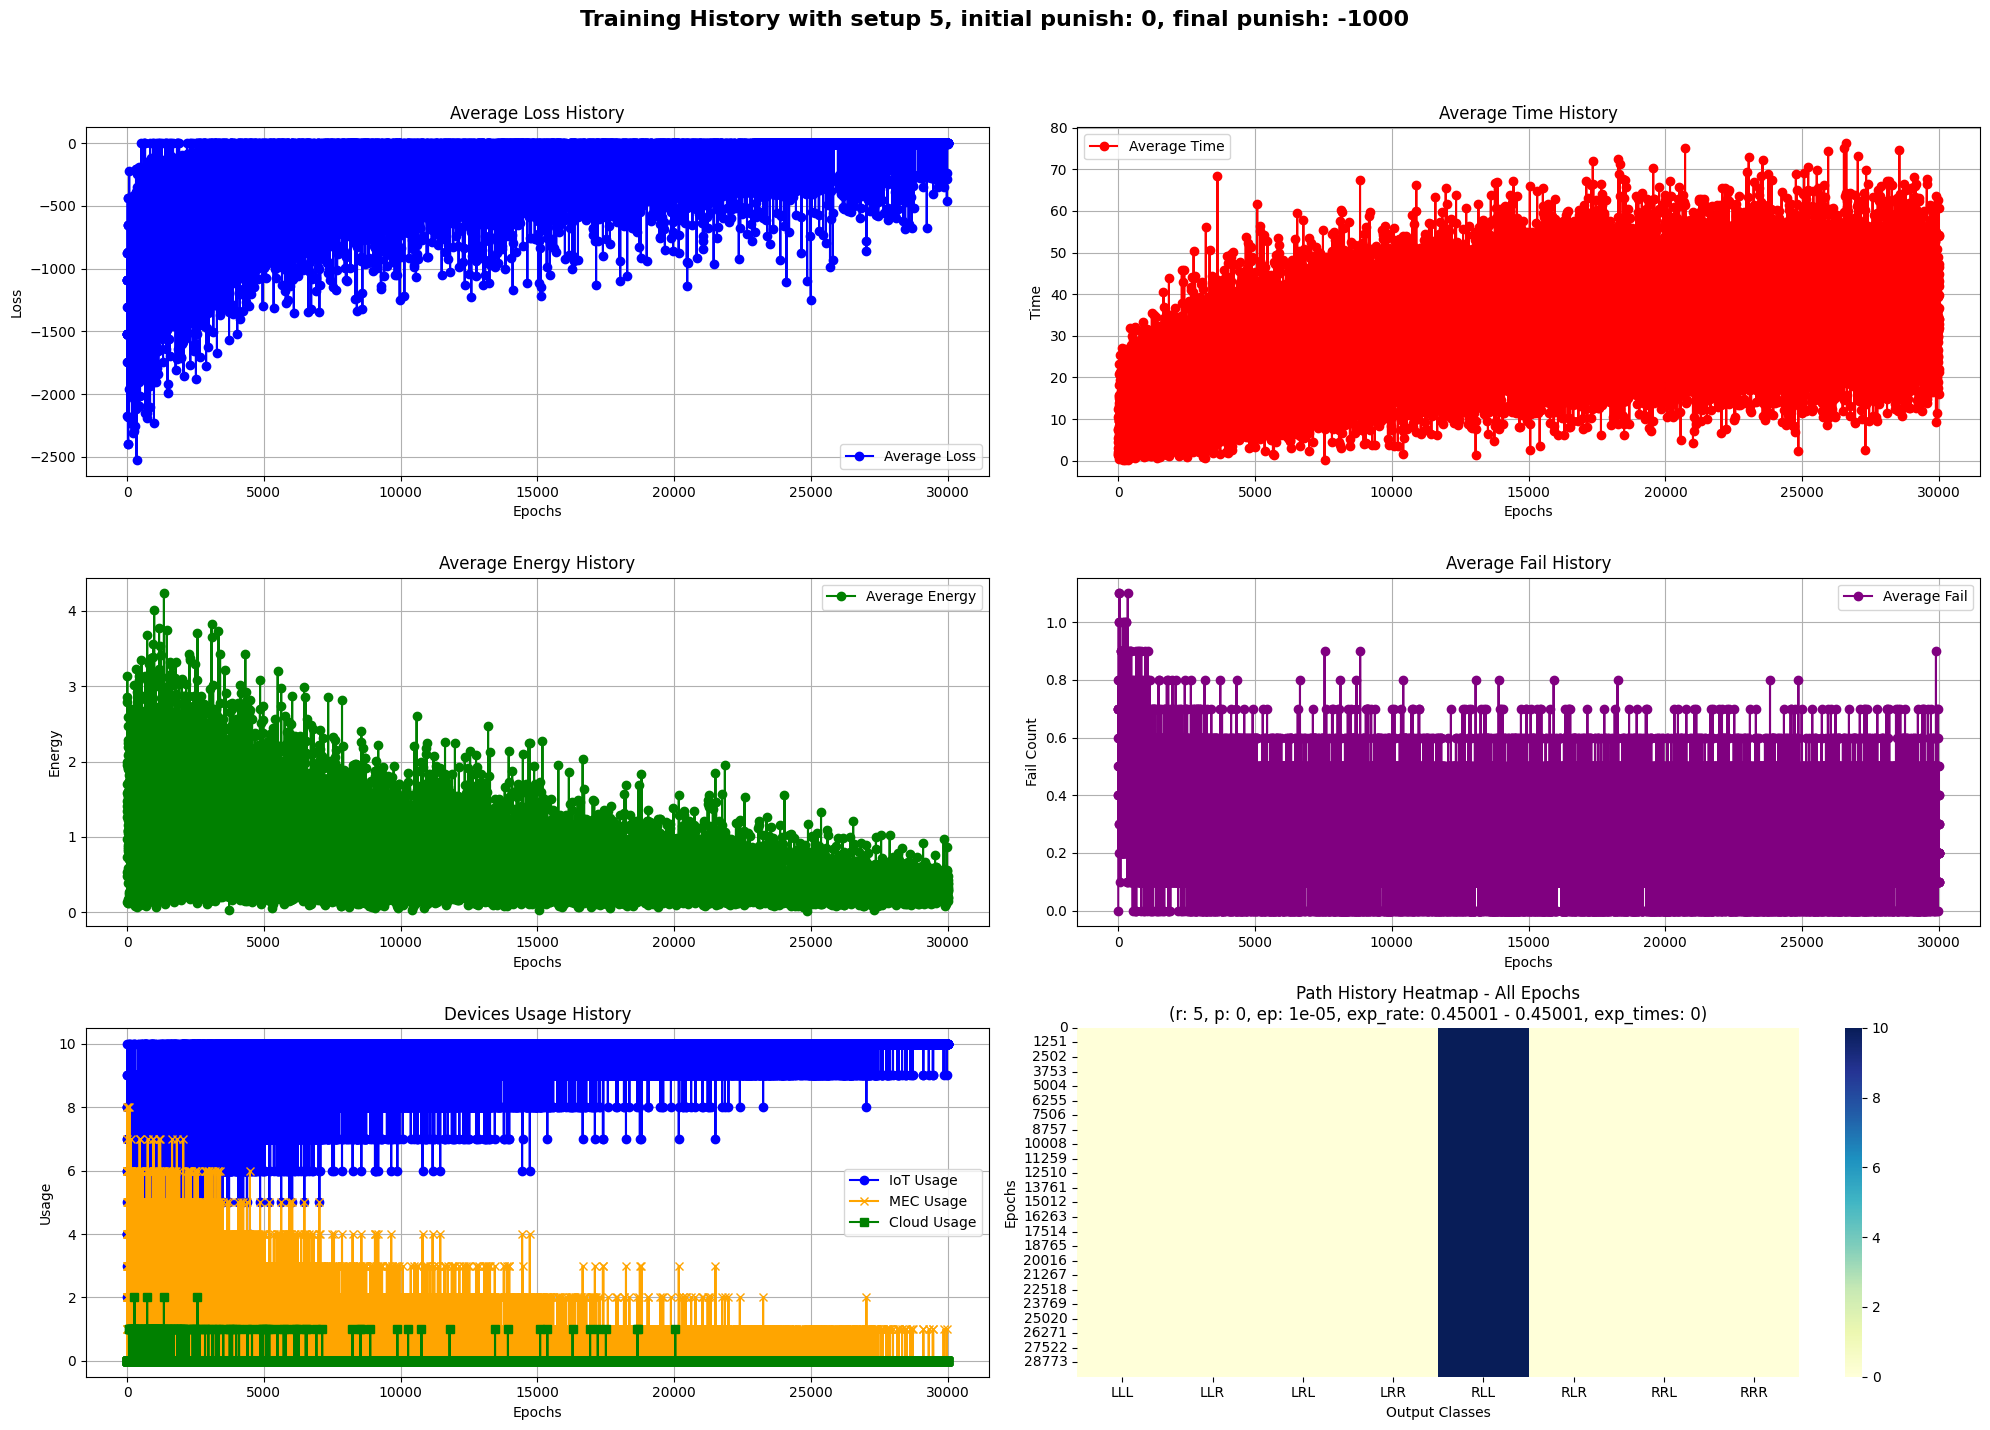

punish epsilon:  0
half epochs punish:  -10


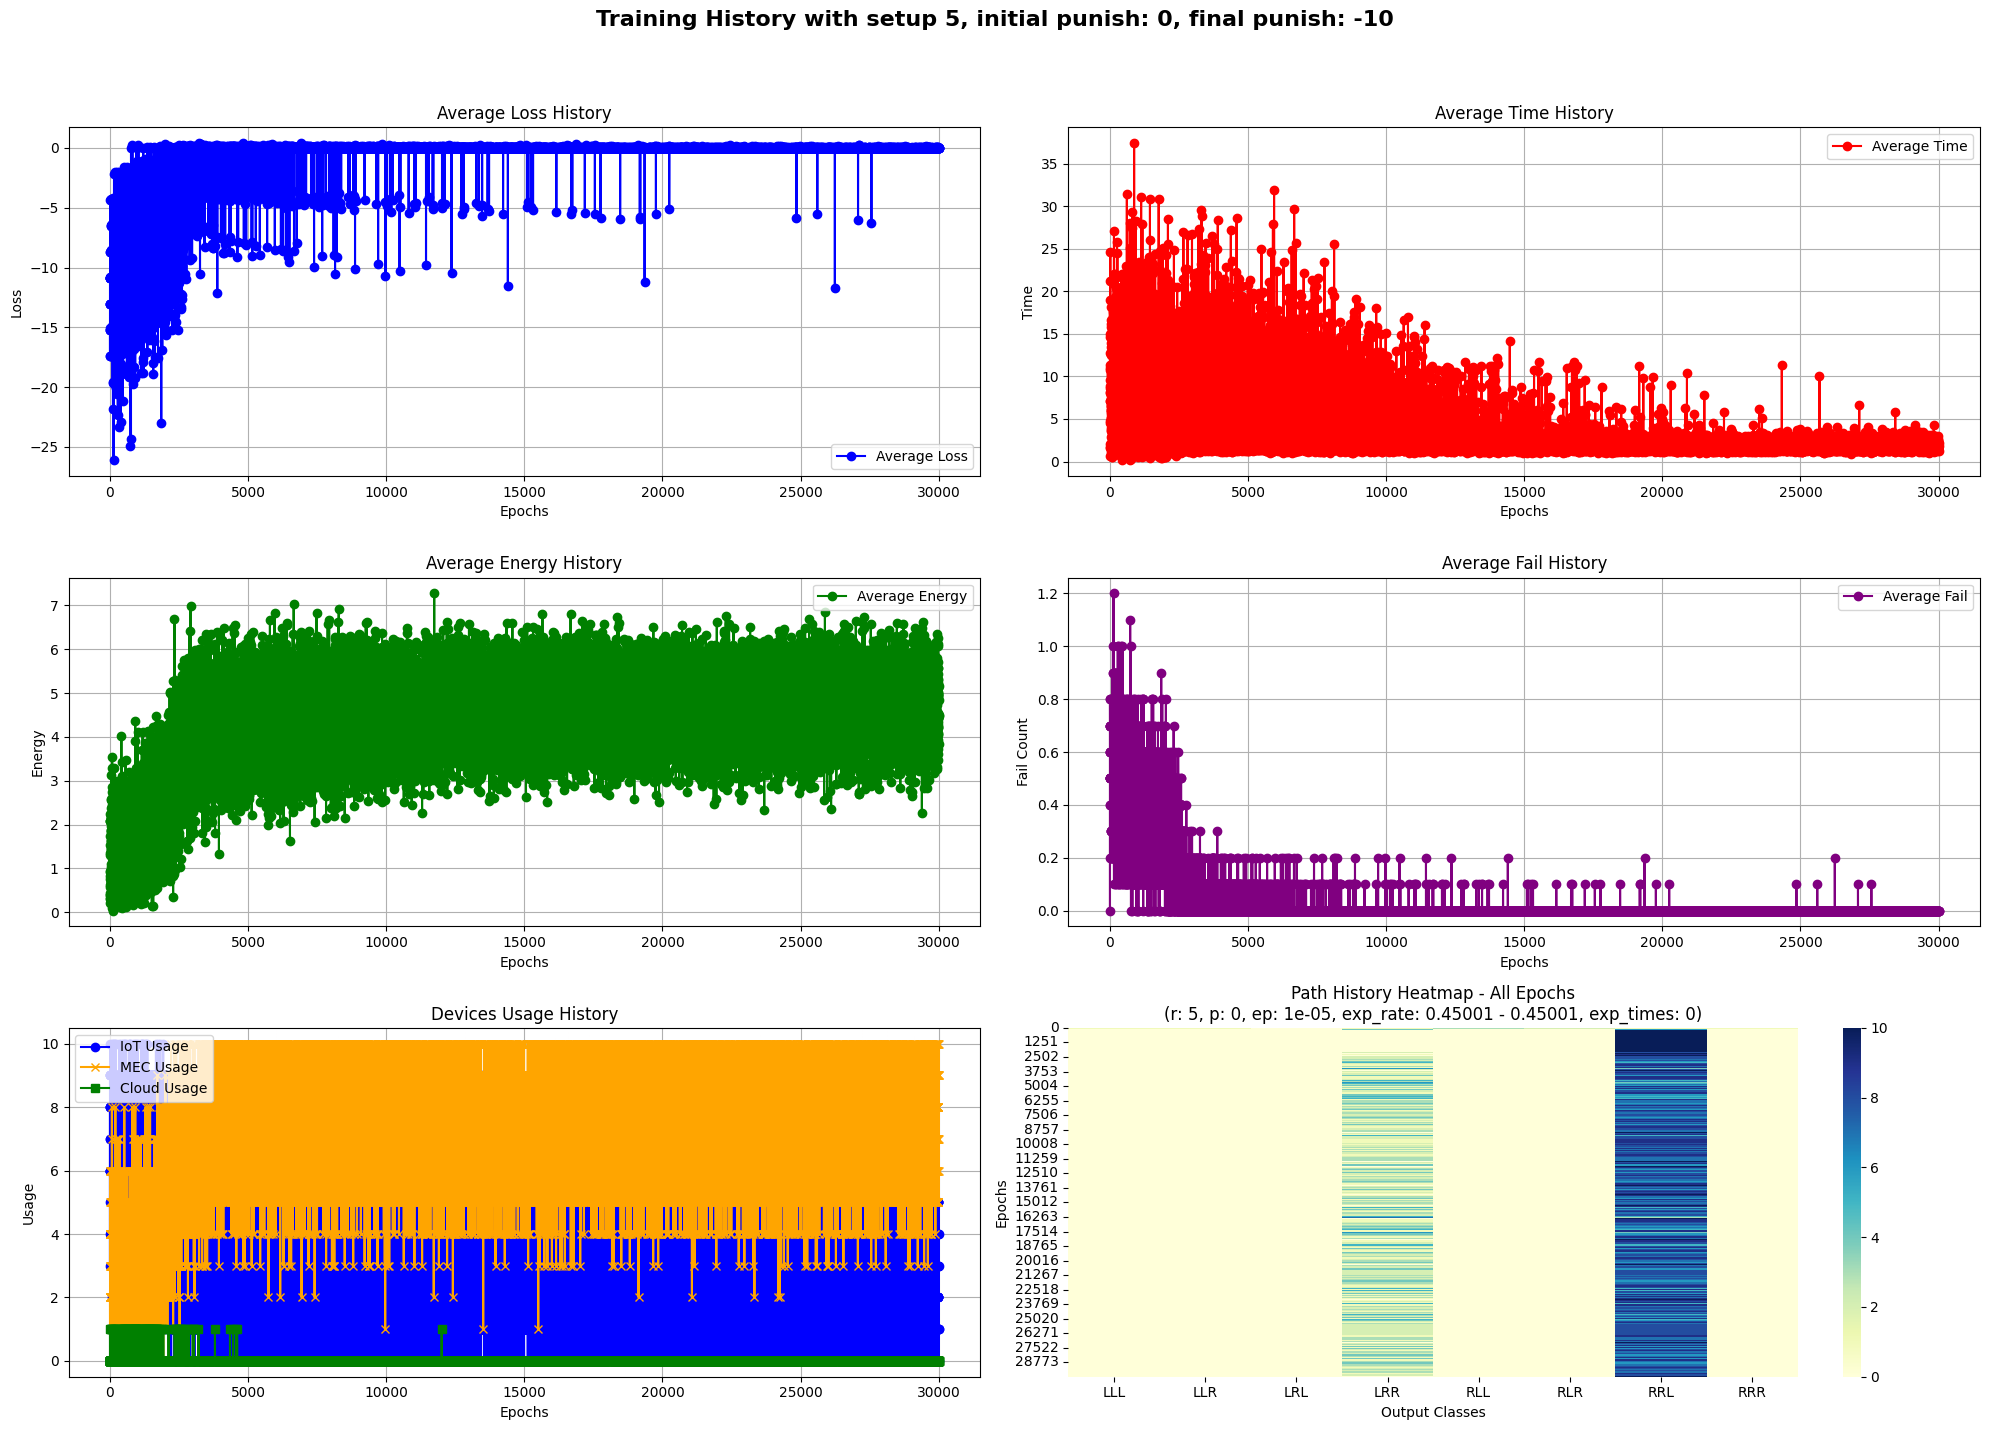

punish epsilon:  0
half epochs punish:  -1000


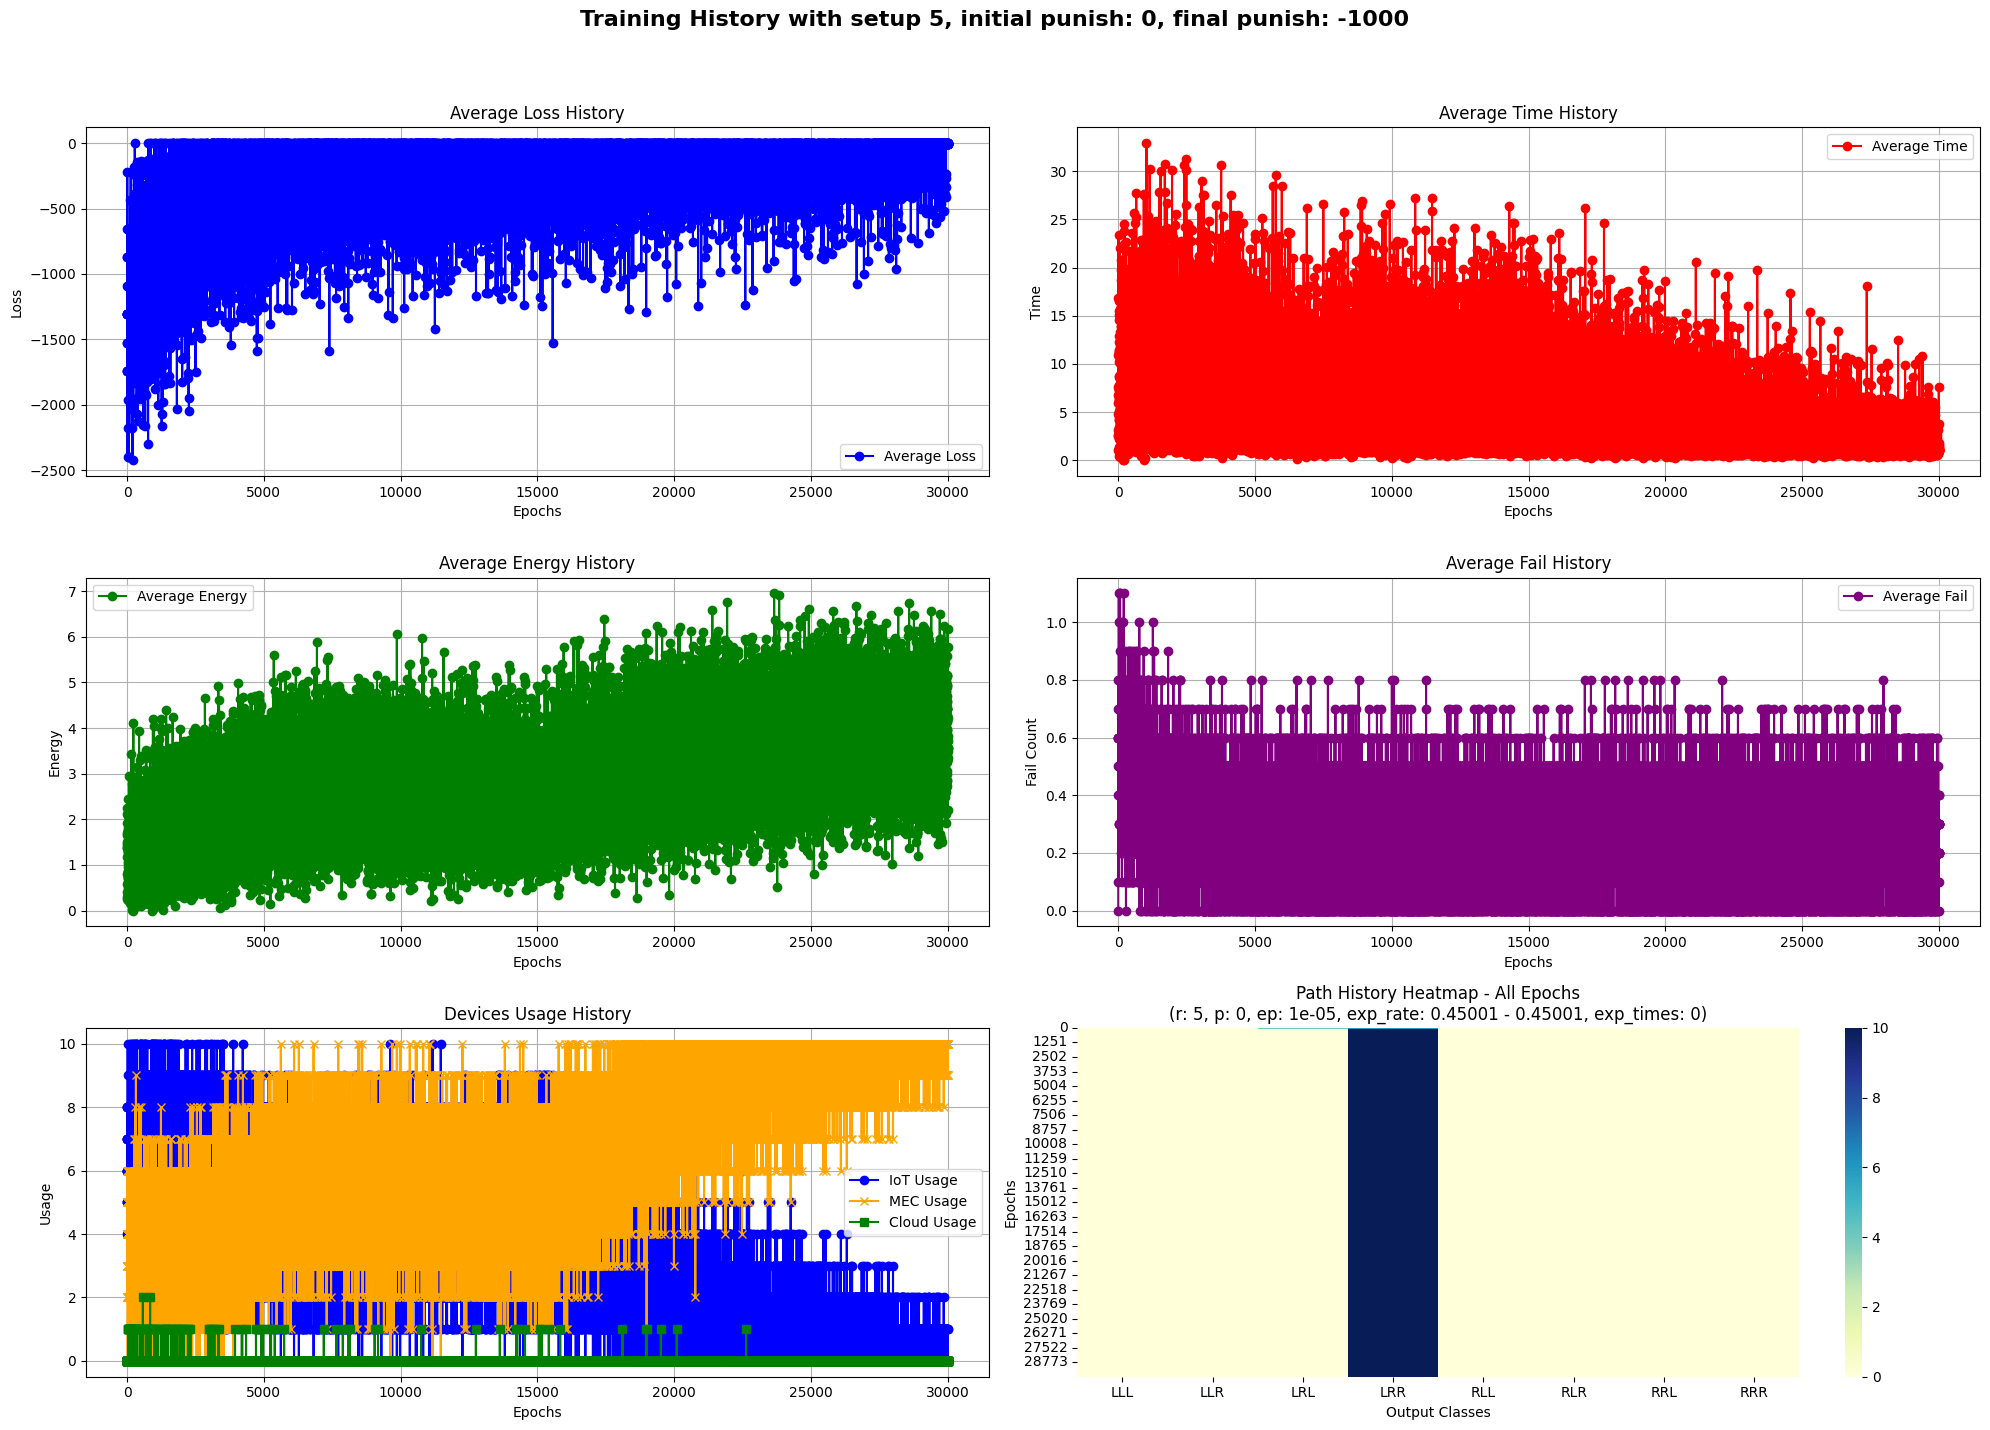

FileNotFoundError: [Errno 2] No such file or directory: './resources/scatterd_tasks.csv'

In [35]:

def train_test(n):
    rpSetup_list = { 5: [-1000,-10]}

    for i in range(n):
        for reward, punishments in rpSetup_list.items():
            for punish in punishments: 
                num_epochs = 30001
                num_episodes = 10
                env = Environment(num_epochs=num_epochs)
                env.rewardSetup = reward
                env.punish = punish
                env.punish_epsilon = 0
                # -(punish - (punish * 10)) / (num_epochs / 2)
                print("punish epsilon: ", env.punish_epsilon)
                
                tree = env.agent
                env.train(num_epochs, num_episodes)
    
train_test(3)   
print("completed")